# Chapter 6. 금융 시계열

pandas는 금융 시계열을 분석하기에 최적인 라이브러리로  
DataFrame클래스나 Series 클래스는 금융 모델링과 분석에 있어서  
의심의 여지 없이 강력한 통계분석 언어인 R에서 착안한 것이다


이번 장에서는 Numpy, pandas로 시간 정보를 다루는 방법과 여러가지 날짜-시간 객체 유형을 상호변환하는 방법을 익힌다.

## 6-1 pandas 기초

pandas는 numpy위에서 구현되었다.
따라서 두 라이브러리를 모두 임포트하는 것으로 시작한다.

In [131]:
import numpy as np
import pandas as pd

### 6-1-1 DataFrame 클래스 다루기 1단계
DataFrame 클래스는 인덱스와 라벨이 붙어있는 자료를 다루기 위해 설계되었다.

In [132]:
# 자료: 자료 자체는 여러 가지 형태와 유형으로 주어질 수 있다.
# 라벨 : 자료는 열column로 구성되고 각 열은 이름을 가질 수 있다.
# 인텍스 : 다른 포맷(숫자, 문자열, 시간 정보 등)으로 된 인덱스가 존재한다.

df = pd.DataFrame([10, 20, 30, 40], columns=['numbers'], index=['a', 'b', 'c', 'd'])
df

,numbers
a,10
b,20
c,30
d,40


In [133]:
# DataFrame사용 예
df.index

Index(['a', 'b', 'c', 'd'], dtype='object')

In [134]:
df.columns

Index(['numbers'], dtype='object')

In [135]:
df.loc['c']

numbers    30
Name: c, dtype: int64

In [136]:
df.loc[['a', 'b']]

,numbers
a,10
b,20


In [137]:
df.loc[df.index[1:3]]

,numbers
b,20
c,30


In [138]:
df.sum()

numbers    100
dtype: int64

In [139]:
df.apply(lambda x: x ** 2)

,numbers
a,100
b,400
c,900
d,1600


In [140]:
# numpy스타일로도 가능하다
df ** 2

,numbers
a,100
b,400
c,900
d,1600


In [141]:
df['floats'] = (1.5, 2.5, 3.5, 4.5)
df

,numbers,floats
a,10,1.5
b,20,2.5
c,30,3.5
d,40,4.5


In [142]:
df['floats']

a    1.5
b    2.5
c    3.5
d    4.5
Name: floats, dtype: float64

In [143]:
# 새로운 열을 정의
df['name'] = pd.DataFrame(['Yyes', 'Guido', 'Felix', 'Francesc'], index = ['d', 'a', 'c', 'b'])
df

,numbers,floats,name
a,10,1.5,Guido
b,20,2.5,Francesc
c,30,3.5,Felix
d,40,4.5,Yyes


In [144]:
# 부적절한 경우
# 이 예제처럼 자료를 직접 넣을 경우에 자칫하면 index가 int로 바뀌기 때문에 직접넣는건 지양한다.
df.append({'numbers':100, 'floats':5.75, 'name':'Henry'}, ignore_index=True)

,numbers,floats,name
0,10,1.50,Guido
1,20,2.50,Francesc
2,30,3.50,Felix
3,40,4.50,Yyes
4,100,5.75,Henry


In [145]:
# 적절한 경우
# 적절한 인덱스 정보와 함께 DataFrame객체를 추가하는 것은 괜찮다.
df = df.append(pd.DataFrame({'numbers':100, 'floats':5.75, 'name':'Henry'}, index=['z',]))
df

,numbers,floats,name
a,10,1.50,Guido
b,20,2.50,Francesc
c,30,3.50,Felix
d,40,4.50,Yyes
z,100,5.75,Henry


pandas의 장점은 누락된 자료를 다루는 것이다.  
다음과 같이 다른 인덱스를 가진 새로운 열을 추가한다.

In [146]:
df.join(pd.DataFrame([1, 4, 9, 16, 25],
                     index=['a', 'b', 'c', 'd', 'y'],
                    columns=['squares',]))

,numbers,floats,name,squares
a,10,1.50,Guido,1.0
b,20,2.50,Francesc,4.0
c,30,3.50,Felix,9.0
d,40,4.50,Yyes,16.0
z,100,5.75,Henry,NaN


y index 도 사라지고 z값은 NaN이 생성되었다.  
이렇게 인덱스가 누락되고값도 보존하기 위해선 아래와 같이 join에 how을 넣는다.

In [147]:
df = df.join(pd.DataFrame([1, 4, 9, 16, 25],
                        index=['a', 'b', 'c', 'd', 'y'],
                        columns=['squares',]),
                        how='outer')
df

,numbers,floats,name,squares
a,10.0,1.50,Guido,1.0
b,20.0,2.50,Francesc,4.0
c,30.0,3.50,Felix,9.0
d,40.0,4.50,Yyes,16.0
y,NaN,NaN,NaN,25.0
z,100.0,5.75,Henry,NaN


누락된 자료가 있어도 대부분의 메서도 호출은 다음과 같이 정상적으로 동작한다.

In [148]:
df[['numbers', 'squares']].mean()

numbers    40.0
squares    11.0
dtype: float64

In [149]:
df[['numbers', 'squares']].std()

numbers    35.355339
squares     9.669540
dtype: float64

### 6-1-2 DataFrame 클래스 다루기 2단계


수치 자료를 이용하여 시계열 자료를 만들기 위해 DatetimeIndex와 같은 기능을 추가해보자

In [150]:
a = np.random.standard_normal((9, 4))
a.round(6)

array([[ 0.815296, -0.549747,  0.832957,  0.764093],
       [-0.739554,  0.378824, -1.51616 ,  0.218856],
       [-0.656756,  1.654496, -1.718912, -0.580231],
       [-0.456581, -0.262204, -2.178693, -0.099348],
       [ 0.781077,  1.554035, -2.239992,  0.02514 ],
       [-2.347688,  1.583358,  0.74638 ,  0.782407],
       [ 0.908997,  0.502777, -0.120299, -0.465133],
       [-0.781517,  1.090962,  1.252665, -0.380459],
       [-1.822359, -0.882699, -0.130099,  1.77199 ]])

In [151]:
df = pd.DataFrame(a)
df

,0,1,2,3
0,0.815296,-0.549747,0.832957,0.764093
1,-0.739554,0.378824,-1.516160,0.218856
2,-0.656756,1.654496,-1.718912,-0.580231
3,-0.456581,-0.262204,-2.178693,-0.099348
4,0.781077,1.554035,-2.239992,0.025140
5,-2.347688,1.583358,0.746380,0.782407
6,0.908997,0.502777,-0.120299,-0.465133
7,-0.781517,1.090962,1.252665,-0.380459
8,-1.822359,-0.882699,-0.130099,1.771990


DataFrame 함수의 인수

> data : ndarray / dict / DataFrame  
> index : Index / array-like  
> columns : Index / array-like  
> dtype : dtype, 디폴트 None  
> copy : bool, 디폴드 None

In [152]:
# 열 개수와 같은 길이의 문자열 리스트를 할당하여 열 이름을 지정할 수 있다.

df.columns = [['No1', 'No2', 'No3', 'No4']]
df

,No1,No2,No3,No4
0,0.815296,-0.549747,0.832957,0.764093
1,-0.739554,0.378824,-1.516160,0.218856
2,-0.656756,1.654496,-1.718912,-0.580231
3,-0.456581,-0.262204,-2.178693,-0.099348
4,0.781077,1.554035,-2.239992,0.025140
5,-2.347688,1.583358,0.746380,0.782407
6,0.908997,0.502777,-0.120299,-0.465133
7,-0.781517,1.090962,1.252665,-0.380459
8,-1.822359,-0.882699,-0.130099,1.771990


In [153]:
# 아래처럼 되야하는데 안된다...
# df['No2'][3]
df['No2']

,No2
0,-0.549747
1,0.378824
2,1.654496
3,-0.262204
4,1.554035
5,1.583358
6,0.502777
7,1.090962
8,-0.882699


date_range 함수의 인수 목록  
start, end, periods, freq, tz, normalize, name

freq(주기 인수)값 종류  
>B, D, M, MS, Q, QS, A, AS, H, S, U, C, W, BM, BMS, BQ, BQS, BA, BAS, T, L

In [154]:
# freq - B: 영업일 단위, M: 월 단위 주기
dates = pd.date_range('2015-1-1', periods=9, freq='M')
dates

DatetimeIndex(['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30'],
              dtype='datetime64[ns]', freq='M')

In [155]:
df.index = dates
df

,No1,No2,No3,No4
2015-01-31,0.815296,-0.549747,0.832957,0.764093
2015-02-28,-0.739554,0.378824,-1.516160,0.218856
2015-03-31,-0.656756,1.654496,-1.718912,-0.580231
2015-04-30,-0.456581,-0.262204,-2.178693,-0.099348
2015-05-31,0.781077,1.554035,-2.239992,0.025140
2015-06-30,-2.347688,1.583358,0.746380,0.782407
2015-07-31,0.908997,0.502777,-0.120299,-0.465133
2015-08-31,-0.781517,1.090962,1.252665,-0.380459
2015-09-30,-1.822359,-0.882699,-0.130099,1.771990


In [156]:
# np-> pandas도 가능하지만 pandas -> np도 가능하다.
np.array(df).round(6)

array([[ 0.815296, -0.549747,  0.832957,  0.764093],
       [-0.739554,  0.378824, -1.51616 ,  0.218856],
       [-0.656756,  1.654496, -1.718912, -0.580231],
       [-0.456581, -0.262204, -2.178693, -0.099348],
       [ 0.781077,  1.554035, -2.239992,  0.02514 ],
       [-2.347688,  1.583358,  0.74638 ,  0.782407],
       [ 0.908997,  0.502777, -0.120299, -0.465133],
       [-0.781517,  1.090962,  1.252665, -0.380459],
       [-1.822359, -0.882699, -0.130099,  1.77199 ]])

### 6-1-3 기초적인 분석

pandas DataFrame 클래스에도 유용한 메서드가 많다.

In [157]:
df.sum()

No1   -4.299085
No2    5.069801
No3   -5.072154
No4    2.037314
dtype: float64

In [158]:
df.mean()

No1   -0.477676
No2    0.563311
No3   -0.563573
No4    0.226368
dtype: float64

In [159]:
df.cumsum()

,No1,No2,No3,No4
2015-01-31,0.815296,-0.549747,0.832957,0.764093
2015-02-28,0.075742,-0.170923,-0.683203,0.982949
2015-03-31,-0.581013,1.483573,-2.402115,0.402718
2015-04-30,-1.037594,1.221369,-4.580808,0.303370
2015-05-31,-0.256517,2.775404,-6.820800,0.328510
2015-06-30,-2.604206,4.358762,-6.074421,1.110916
2015-07-31,-1.695209,4.861539,-6.194720,0.645783
2015-08-31,-2.476726,5.952501,-4.942055,0.265324
2015-09-30,-4.299085,5.069801,-5.072154,2.037314


In [160]:
df.describe()

,No1,No2,No3,No4
count,9.000000,9.000000,9.000000,9.000000
mean,-0.477676,0.563311,-0.563573,0.226368
std,1.155294,0.970834,1.369791,0.760833
min,-2.347688,-0.882699,-2.239992,-0.580231
25%,-0.781517,-0.262204,-1.718912,-0.380459
50%,-0.656756,0.502777,-0.130099,0.025140
75%,0.781077,1.554035,0.746380,0.764093
max,0.908997,1.654496,1.252665,1.771990


In [161]:
np.sqrt(df)

C:\Users\hklee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


,No1,No2,No3,No4
2015-01-31,0.902938,NaN,0.912665,0.874124
2015-02-28,NaN,0.615486,NaN,0.467821
2015-03-31,NaN,1.286272,NaN,NaN
2015-04-30,NaN,NaN,NaN,NaN
2015-05-31,0.883786,1.246609,NaN,0.158557
2015-06-30,NaN,1.258315,0.863933,0.884537
2015-07-31,0.953413,0.709068,NaN,NaN
2015-08-31,NaN,1.044491,1.119225,NaN
2015-09-30,NaN,NaN,NaN,1.331161


pandas는 오류를 검출하고 해당 수학 연산이 실패한 위치에 NaN값을 집어넣는 오류 내성(falut tolerance)을 가진다.
많은 경우에 불완전한 자료도 완전한 자료처럼 처리하는 것이 가능하다.

In [162]:
np.sqrt(df).sum()

C:\Users\hklee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


No1    2.740136
No2    6.160243
No3    2.895823
No4    3.716200
dtype: float64

자료를 시각화하는 것도 한 줄로 가능하다

plot의 속성값은 189page에 적혀있다.

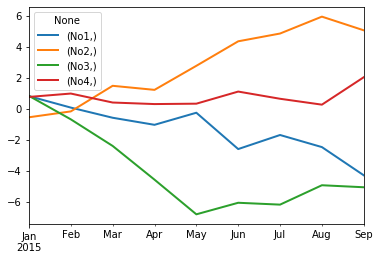

In [163]:
%matplotlib inline
df.cumsum().plot(lw=2.0)

### 6-1-4 Series 클래스

pandas에는 단일 시계열 전용의 Series 클래스도 존재한다.  
예를 들면 DataFrame 객체에서 하나의 열만 선택하면 Series 객체를 얻을 수 있다.

In [164]:
type(df)

pandas.core.frame.DataFrame

In [165]:
df['No1']

,No1
2015-01-31,0.815296
2015-02-28,-0.739554
2015-03-31,-0.656756
2015-04-30,-0.456581
2015-05-31,0.781077
2015-06-30,-2.347688
2015-07-31,0.908997
2015-08-31,-0.781517
2015-09-30,-1.822359


In [166]:
type(df['No1'])

pandas.core.frame.DataFrame

Text(0, 0.5, 'value')

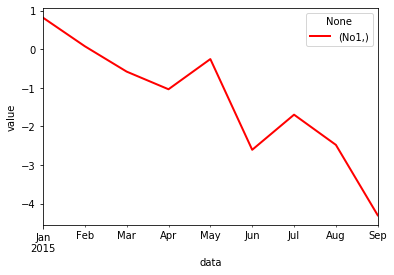

In [167]:
import matplotlib.pyplot as plt

df['No1'].cumsum().plot(style='r', lw=2.)
plt.xlabel('data')
plt.ylabel('value')

### 6-1-5 GroupBy 연산

pandas는 groupby라는 강력하고 유연한 그룹 지정 기능을 갖기고 있다.  
이 기능은 SQL의 그룹 지정 기능이나 마이크로소프트 엑셀의 피봇 테이블과 비슷하다.

In [168]:
df['Quarter'] = ['Q1', 'Q1', 'Q1', 'Q2', 'Q2', 'Q2', 'Q3', 'Q3', 'Q3']
df

,No1,No2,No3,No4,Quarter
2015-01-31,0.815296,-0.549747,0.832957,0.764093,Q1
2015-02-28,-0.739554,0.378824,-1.516160,0.218856,Q1
2015-03-31,-0.656756,1.654496,-1.718912,-0.580231,Q1
2015-04-30,-0.456581,-0.262204,-2.178693,-0.099348,Q2
2015-05-31,0.781077,1.554035,-2.239992,0.025140,Q2
2015-06-30,-2.347688,1.583358,0.746380,0.782407,Q2
2015-07-31,0.908997,0.502777,-0.120299,-0.465133,Q3
2015-08-31,-0.781517,1.090962,1.252665,-0.380459,Q3
2015-09-30,-1.822359,-0.882699,-0.130099,1.771990,Q3


In [172]:
# 이상하게 에러가 나옴...
# groups = df.groupby('No2')

ValueError: Grouper for 'No2' not 1-dimensional

In [173]:
# groups.mean()
# groups.max()
# groups.size()
# 193 page 생략됨

## 6-2 금융 자료

194 페이지 부터